In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import torch.nn as nn
# Define the FastF1Dataset class
class FastF1Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx + self.sequence_length], dtype=torch.float32)

# Load your saved model
def load_model(model_path, model_class, sequence_length, input_dim, device):
    model = model_class(sequence_length, input_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Calculate reconstruction error
def compute_reconstruction_error(inputs, outputs):
    return torch.mean((inputs - outputs) ** 2, dim=1).detach().numpy()


# Define your autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, sequence_length, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(num_features, 64, batch_first=True)
        self.latent = nn.LSTM(64, 32, batch_first=True)
        self.decoder = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, num_features)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.latent(x[:, -1].unsqueeze(1).repeat(1, x.size(1), 1))
        x, _ = self.decoder(x)
        x = self.output_layer(x)
        return x

# Set paths and parameters
model_path = "AD_19-23_autoencoder_AdamW_lr0001_loss0.4037_fold5.pth"
new_data_path = "2024_LasVegasGrandPrix_GAS_MinMaxScaler_normalized_complete.npz"
sequence_length = 20
threshold = 500

# Load the new data
new_data = np.load(new_data_path, allow_pickle=True)['data']
new_data_array = np.array(new_data, dtype=np.float32)

# Create the test dataset and data loader
test_dataset = FastF1Dataset(new_data_array, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = new_data_array.shape[1]  # Number of features per timestep
autoencoder = load_model(model_path, LSTMAutoencoder, sequence_length, input_dim, device).to(device)

# Test the model
def test_autoencoder(autoencoder, data_loader, device):
    autoencoder.eval()
    errors = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.to(device)
            outputs = autoencoder(inputs)
            batch_errors = compute_reconstruction_error(inputs, outputs)
            errors.extend(batch_errors)

    return np.array(errors)

reconstruction_errors = test_autoencoder(autoencoder, test_loader, device)

# Set a threshold for anomalies


In [11]:
len(new_data)

9029

In [118]:
def plot_reconstruction_errors_with_threshold(errors, threshold=None):
    """
    Plots reconstruction errors as a line graph with an optional threshold.

    Parameters:
        errors (np.array): Array of reconstruction errors.
        threshold (float, optional): Threshold for detecting anomalies. Defaults to None.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(errors, label="Reconstruction Errors", color='blue', linewidth=1.5)
    
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    
    plt.xlabel("Sample Index")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Errors with Threshold")
    
    # Aggiungi legenda una sola volta
    # plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.show()


In [5]:
threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)
# threshold = np.percentile(reconstruction_errors, 99.9)

# Visualize errors
# visualize_reconstruction_errors(reconstruction_errors, threshold=threshold)

# Print anomalies
anomalies = reconstruction_errors > threshold
print(f"Total anomalies detected: {np.sum(anomalies)}")

Total anomalies detected: 244


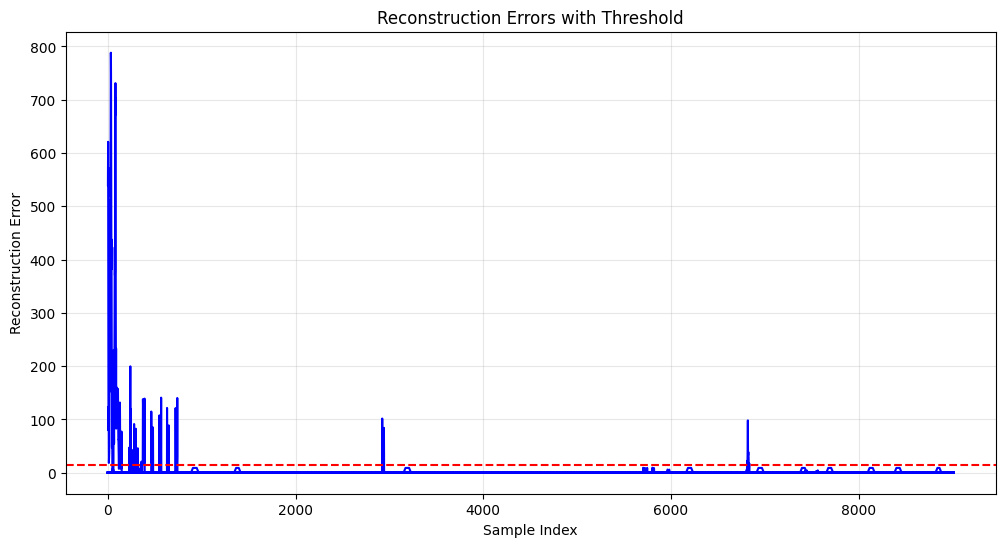

In [119]:
plot_reconstruction_errors_with_threshold(reconstruction_errors, threshold=threshold)

In [110]:
len(reconstruction_errors)

9010

In [6]:
# Find the indexes where anomalies are True
indexes = np.where(anomalies == True)[0]

# Group consecutive True blocks, allowing gaps of up to 5
blocks = []
block = []

for i in range(len(indexes)):
    if not block or indexes[i] <= block[-1] + 5:
        # Start a new block or extend the current one
        block.append(indexes[i])
    else:
        # Close the current block and start a new one
        blocks.append(block)
        block = [indexes[i]]

# Append the last block
if block:
    blocks.append(block)

print(blocks)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115], [123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 144, 145], [226], [236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254], [279, 280, 281, 282, 283, 284, 285, 286, 287, 288], [296, 297, 302, 303], [309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321], [357], [367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390], [462, 463, 464, 465, 466, 467, 468, 469, 470], [479, 480], [549, 550], [563, 564, 565, 566, 567], [630, 631, 632, 63

In [106]:
len(blocks)

20

In [10]:
minutes_to_exlude = 5 # around first 3 laps
# Exclude first laps
first_lap_sequences = int((minutes_to_exlude * 60 * 1000) / 240)  # (minutes_to_exlude in milliseconds / length of a row)
count = 0
for block in blocks:
    if len(block) > 1:
        if block[0] > first_lap_sequences:
            print(f"Anomaly detected from timestep {block[0]}, with len {len(block)+20}")
            count += 1
print(f"Total anomalies detected: {count}")

Anomaly detected from timestep 2923, with len 22
Anomaly detected from timestep 2940, with len 22
Anomaly detected from timestep 6811, with len 37
Total anomalies detected: 3
